In [1]:
import sys
sys.path.append("../")
sys.path.append("../..")

In [3]:
# For reproducibility
import random
random.seed(0)
VAL_SIZE = 38
SUBMISSION_NAME = "first_lightgbm"

In [4]:
# %% Imports
import pandas as pd
import sys
from metrics.metric_participants import ComputeMetrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
import random

from eda.checker import check_train_test

# read data

In [21]:
sales_train = pd.read_csv("../data/data_raw/sales_train.csv")
df_full = pd.read_csv("../data/split.csv")
df_region = pd.read_csv("../data/data_raw/regions.csv")
regions_hcps = pd.read_csv("../data/data_raw/regions_hcps.csv")
activity_features = pd.read_csv("../data/features/activity_features.csv")
brands_3_12 = pd.read_csv("../data/features/brand_3_12_market_features_lagged.csv")
rte_basic = pd.read_csv("../data/features/rte_basic_features.csv").drop(    columns=["sales", "validation"])

train_correlation_features = pd.read_csv("../data/features/train_correlation_features_for_validation.csv")
test_correlation_features = pd.read_csv("../data/features/test_correlation_features_for_validation.csv")
correlation_features = pd.concat([train_correlation_features, test_correlation_features]).reset_index(drop=True)
# correlation_features = correlation_features[['month', 'region', 'brand_1_similar_mean', 'brand_2_similar_mean']]

In [125]:
correlation_features.columns

Index(['month', 'region', 'brand_1_similar_mean', 'brand_2_similar_mean',
       'brand_1_similar_std', 'brand_2_similar_std',
       'brand_1_similar_percentile_10', 'brand_2_similar_percentile_10',
       'brand_1_similar_percentile_90', 'brand_2_similar_percentile_90',
       'brand_1_similar_min', 'brand_2_similar_min', 'brand_1_similar_max',
       'brand_2_similar_max'],
      dtype='object')

# merge

In [22]:
import numpy as np

In [23]:
# %% Add region data
df_feats = df_full.merge(df_region, on="region", how="left")
df_feats = pd.merge(left=df_feats, right=regions_hcps, how="left", on="region")
df_feats = df_feats.merge(
    activity_features, on=["month", "region", "brand"], how="left"
)
df_feats = df_feats.merge(
    correlation_features, on=["month", "region"], how="left"
)
df_feats = df_feats.merge(rte_basic, on=["month", "region", "brand"], how="left")
df_feats = df_feats.merge(brands_3_12, on=["month", "region"], how="left")
df_feats["whichBrand"] = np.where(df_feats.brand == "brand_1", 1, 0)


In [24]:
# drop sum variables
cols_to_drop = ["month", "region", "brand", "sales", "validation"]


# %% Split train val test
X_train = df_feats.query("validation == 0").drop(columns=cols_to_drop)
y_train = df_feats.query("validation == 0").sales

X_val = df_feats.query("validation == 1").drop(columns=cols_to_drop)
y_val = df_feats.query("validation == 1").sales

In [34]:
X_train.head().T

,0,1,4,5,6
population,3.819580e+05,3.819580e+05,3.180260e+05,3.180260e+05,3.438610e+05
area_x,1.372441e+03,1.372441e+03,2.574944e+03,2.574944e+03,3.639373e+03
pci16_x,3.879997e+04,3.879997e+04,4.257802e+04,4.257802e+04,4.685649e+04
pci18_x,4.021490e+04,4.021490e+04,4.445639e+04,4.445639e+04,4.856423e+04
area_y,1.372441e+03,1.372441e+03,2.574944e+03,2.574944e+03,3.639373e+03
...,...,...,...,...,...
sales_brand_12_marketshift10,3.884150e+05,3.884150e+05,2.727380e+05,2.727380e+05,3.017465e+05
sales_brand_12_marketshift11,1.652738e+05,1.652738e+05,5.804014e+05,5.804014e+05,2.543808e+05
sales_brand_3_market_per_region,1.875501e+07,1.875501e+07,9.541553e+06,9.541553e+06,8.111375e+06
sales_brand_12_market_per_region,1.066696e+07,1.066696e+07,4.650556e+06,4.650556e+06,4.712618e+06


# fit

In [25]:
# %%
lgbms = {}
pipes = {}
train_preds = {}
val_preds = {}
test_preds = {}

for quantile in [0.5, 0.1, 0.9]:

    lgbms[quantile] = LGBMRegressor(
        n_jobs=-1,
        n_estimators=50,
        objective="quantile",
        alpha=quantile,
    )

    pipes[quantile] = Pipeline(
        [("imputer", SimpleImputer(strategy="median")), ("lgb", lgbms[quantile])]
    )

    # Fit cv model
    pipes[quantile].fit(X_train, y_train)

    train_preds[quantile] = pipes[quantile].predict(X_train)
    val_preds[quantile] = pipes[quantile].predict(X_val)

In [126]:
df_feats

,month,region,brand,sales,validation,population,area_x,pci16_x,pci18_x,area_y,...,sales_brand_12_marketshift5,sales_brand_12_marketshift6,sales_brand_12_marketshift7,sales_brand_12_marketshift8,sales_brand_12_marketshift9,sales_brand_12_marketshift10,sales_brand_12_marketshift11,sales_brand_3_market_per_region,sales_brand_12_market_per_region,whichBrand
0,2020-07,region_0,brand_1,0.00,0.0,381958,1372.440545,38799.972381,40214.895762,1372.440545,...,222306.12,480402.71,162082.27,328934.96,267012.51,388414.99,165273.82,18755013.60,10666956.92,1
1,2020-07,region_0,brand_2,0.00,0.0,381958,1372.440545,38799.972381,40214.895762,1372.440545,...,222306.12,480402.71,162082.27,328934.96,267012.51,388414.99,165273.82,18755013.60,10666956.92,0
2,2020-07,region_1,brand_1,0.00,1.0,431383,4701.726213,45377.708041,47137.854237,4701.726213,...,294727.92,222306.12,480402.71,162082.27,328934.96,267012.51,388414.99,12009449.36,6803632.80,1
3,2020-07,region_1,brand_2,143.74,1.0,431383,4701.726213,45377.708041,47137.854237,4701.726213,...,294727.92,222306.12,480402.71,162082.27,328934.96,267012.51,388414.99,12009449.36,6803632.80,0
4,2020-07,region_2,brand_1,0.00,0.0,318026,2574.943849,42578.018793,44456.389595,2574.943849,...,153871.22,444736.78,320960.48,234047.10,308306.64,272737.97,580401.41,9541553.05,4650556.48,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5623,2021-08,region_198,brand_2,NaN,NaN,374756,6500.068131,43452.297389,45337.580895,6500.068131,...,257088.76,206344.42,409169.01,305803.26,609860.47,362865.99,271690.30,11137991.32,5601796.70,0
5624,2021-08,region_199,brand_1,NaN,NaN,319660,2309.103167,40976.821501,42691.767247,2309.103167,...,390273.47,257088.76,206344.42,409169.01,305803.26,609860.47,362865.99,11405472.05,6112388.64,1
5625,2021-08,region_199,brand_2,NaN,NaN,319660,2309.103167,40976.821501,42691.767247,2309.103167,...,390273.47,257088.76,206344.42,409169.01,305803.26,609860.47,362865.99,11405472.05,6112388.64,0
5626,2021-08,region_200,brand_1,NaN,NaN,395114,2598.725436,44282.292557,46215.140591,2598.725436,...,197299.43,274538.96,140895.48,390273.47,257088.76,206344.42,409169.01,12149692.64,6644712.06,1


In [26]:
# %% Train prediction
train_preds_df = (
    df_feats.query("validation == 0")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=train_preds[0.5])
    .assign(lower=train_preds[0.1].clip(0))
    .assign(upper=train_preds[0.9])
)

In [27]:
ground_truth_train = df_feats.query("validation == 0").loc[
    :, ["month", "region", "brand", "sales"]
]

In [28]:
ComputeMetrics(train_preds_df, sales_train, ground_truth_train)

(22.403355252459964, 85.2859700272765)

In [29]:
# %% Validation prediction
val_preds_df = (
    df_feats.query("validation == 1")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=val_preds[0.5])
    .assign(lower=val_preds[0.1].clip(0))
    .assign(upper=val_preds[0.9])
)

ground_truth_val = df_feats.query("validation == 1").loc[
    :, ["month", "region", "brand", "sales"]
]

val_preds_df.loc[val_preds_df['sales'] < 0, 'sales'] = 0

idx = val_preds_df['sales'] < val_preds_df['lower']
val_preds_df.loc[idx, 'lower'] = val_preds_df.loc[idx, 'sales']

idx = val_preds_df['sales'] > val_preds_df['upper']
val_preds_df.loc[idx, 'upper'] = val_preds_df.loc[idx, 'sales']

ComputeMetrics(val_preds_df, sales_train, ground_truth_val)

(36.68481395582958, 151.6369684367356)

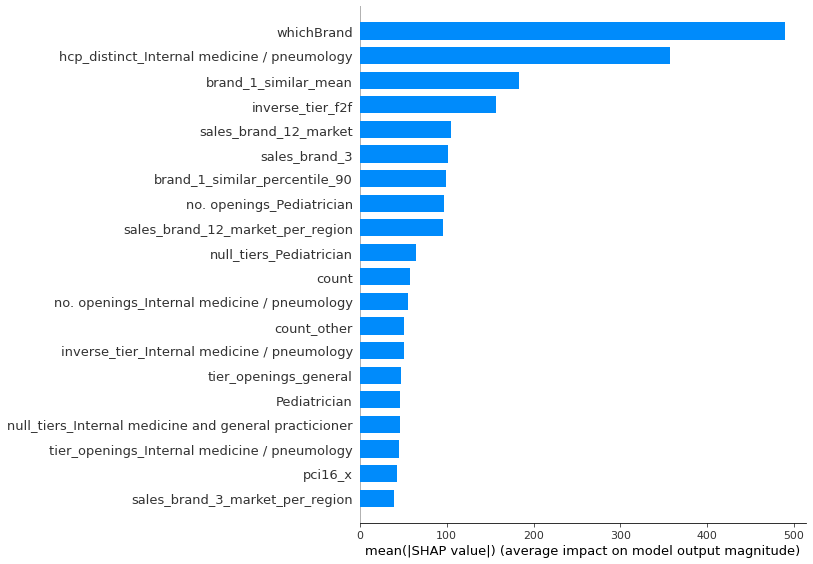

In [30]:
import shap
explainer = shap.TreeExplainer(lgbms[0.5])
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')


In [115]:
x = {0.1: np.array([-1., 1., 1., 7.]), 
     0.5: np.array([2., -2., 2., 2.]),
     0.9: np.array([5., 5., 5., 5.])}
l = x[0.1]
m = x[0.5]
u = x[0.9]

In [116]:
print(l, m, u)

[-1.  1.  1.  7.] [ 2. -2.  2.  2.] [5. 5. 5. 5.]


In [123]:
def postprocess_predictions(predictions):
    for p, pred in predictions.items():
        pred[pred < 0] = 0
        x[p] = pred
    l = x[0.1]
    m = x[0.5]
    u = x[0.9]
    idx = l > m
    l[idx] = m[idx]
    idx = u < m
    u[idx] = m[idx]
    x[0.1] = l
    x[0.5] = m
    x[0.9] = u
    return x

In [124]:
postprocess_predictions(x)

{0.1: array([0., 0., 1., 2.]),
 0.5: array([2., 0., 2., 2.]),
 0.9: array([5., 5., 5., 5.])}

In [118]:
print(l, m, u)

[0. 1. 1. 7.] [2. 0. 2. 2.] [5. 5. 5. 5.]


In [119]:
print(l, m, u)

[0. 0. 1. 2.] [2. 0. 2. 2.] [5. 5. 5. 5.]


In [120]:
print(l, m, u)

[0. 0. 1. 2.] [2. 0. 2. 2.] [5. 5. 5. 5.]
